# 6 - 文本分类微调

## 1 - 微调的类别

## 2 - 准备数据集

数据路径 - sms_spam_collection/SMSSpamCollection.tsv

In [1]:
# 读取为 DataFrame

from pathlib import Path
import pandas as pd

extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])

In [2]:
# 统计标签数量

print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


交叉验证 - 简单的平衡处理

In [3]:
def create_balanced_dataset(df):
    # 选择Label为spam的列，再shape[0]得有多少行
    num_spam = df[df["Label"] == "spam"].shape[0]
    # 抽取num_spam个Label为ham的列
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    # 合并
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


特征工程

In [4]:
# ham to 0， spam to 1

balanced_df["Label"] = balanced_df["Label"].map({
    "ham": 0,
    "spam": 1
})

划分训练，验证，测试集

In [5]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)
    
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    
    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## 3 - 创建数据加载器

text长度不同，需截断或补长
* 这里选择全部补长到最长text长度，使用'<|endoftext|>'作为补充token

In [6]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [7]:
# 找到最长长度并补充其他text

import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    """找到最长长度并补充其他text

    Args:
        Dataset : torch的数据集类型
    """
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]
        
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
    
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
    
    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [8]:
# 训练集

train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)
print(train_dataset.max_length)

120


In [9]:
# 验证集

val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

# 测试集
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

创建数据加载器

In [10]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

测试

In [11]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)


Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [12]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## 4 - 使用预训练权重初始化模型

初始化预训练模型，原本的下载方式 base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"，文件已经移动。
替换策略：从hugging face加载。

In [13]:
from transformers import GPT2Model


# allowed model names
model_names = {
    "gpt2-small (124M)": "openai-community/gpt2",
    "gpt2-medium (355M)": "openai-community/gpt2-medium",
    "gpt2-large (774M)": "openai-community/gpt2-large",
    "gpt2-xl (1558M)": "openai-community/gpt2-xl"
}

CHOOSE_MODEL = "gpt2-small (124M)"

gpt_hf = GPT2Model.from_pretrained(model_names[CHOOSE_MODEL], cache_dir="checkpoints")
gpt_hf.eval()

/opt/miniconda3/envs/LLMs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [14]:
# 模型参数

BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}


BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [15]:
def assign_check(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(right.clone().detach())

In [16]:
# 加载权重

import numpy as np


def load_weights(gpt, gpt_hf):

    d = gpt_hf.state_dict()

    gpt.pos_emb.weight = assign_check(gpt.pos_emb.weight, d["wpe.weight"])
    gpt.tok_emb.weight = assign_check(gpt.tok_emb.weight, d["wte.weight"])
    
    for b in range(BASE_CONFIG["n_layers"]):
        q_w, k_w, v_w = np.split(d[f"h.{b}.attn.c_attn.weight"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign_check(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign_check(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign_check(gpt.trf_blocks[b].att.W_value.weight, v_w.T)
    
        q_b, k_b, v_b = np.split(d[f"h.{b}.attn.c_attn.bias"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign_check(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign_check(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign_check(gpt.trf_blocks[b].att.W_value.bias, v_b)
    
    
        gpt.trf_blocks[b].att.out_proj.weight = assign_check(gpt.trf_blocks[b].att.out_proj.weight, d[f"h.{b}.attn.c_proj.weight"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign_check(gpt.trf_blocks[b].att.out_proj.bias, d[f"h.{b}.attn.c_proj.bias"])
    
        gpt.trf_blocks[b].ff.layers[0].weight = assign_check(gpt.trf_blocks[b].ff.layers[0].weight, d[f"h.{b}.mlp.c_fc.weight"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign_check(gpt.trf_blocks[b].ff.layers[0].bias, d[f"h.{b}.mlp.c_fc.bias"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign_check(gpt.trf_blocks[b].ff.layers[2].weight, d[f"h.{b}.mlp.c_proj.weight"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign_check(gpt.trf_blocks[b].ff.layers[2].bias, d[f"h.{b}.mlp.c_proj.bias"])
    
        gpt.trf_blocks[b].norm1.scale = assign_check(gpt.trf_blocks[b].norm1.scale, d[f"h.{b}.ln_1.weight"])
        gpt.trf_blocks[b].norm1.shift = assign_check(gpt.trf_blocks[b].norm1.shift, d[f"h.{b}.ln_1.bias"])
        gpt.trf_blocks[b].norm2.scale = assign_check(gpt.trf_blocks[b].norm2.scale, d[f"h.{b}.ln_2.weight"])
        gpt.trf_blocks[b].norm2.shift = assign_check(gpt.trf_blocks[b].norm2.shift, d[f"h.{b}.ln_2.bias"])
    
        gpt.final_norm.scale = assign_check(gpt.final_norm.scale, d[f"ln_f.weight"])
        gpt.final_norm.shift = assign_check(gpt.final_norm.shift, d[f"ln_f.bias"])
        gpt.out_head.weight = assign_check(gpt.out_head.weight, d["wte.weight"])

In [20]:
import torch
from previous_chapters import GPTModel


model = GPTModel(BASE_CONFIG)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_weights(model, gpt_hf)

In [21]:
import tiktoken
from previous_chapters import generate, text_to_token_ids, token_ids_to_text

torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate(
    model=model.to(device),
    idx=text_to_token_ids("Every effort moves", tokenizer).to(device),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"],
    top_k=1,
    temperature=1.0
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves forward, but it's not enough.

"I'm not going to sit here and say, 'I'm not going to do this,'


In [22]:
from previous_chapters import generate_text_simple

text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model.to(device),
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


## 5 - 添加分类头


修改预训练LLM实现分类任务

In [23]:
# 看模型结构

print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

### 微调输出层

1. 让所有层都不可训练

In [24]:
for param in model.parameters():
    param.requires_grad = False

2. 替换最后一层
理论上可以只训练最后一层，但实验表明一起训练前面一点的，效果更好。
> 我们训练最后三层

In [25]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [28]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [26]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [27]:
# 测试

inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])
Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


## 6 - 计算分类损失和准确率

使用softmax将输出转换为标签概率

In [30]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


* 准确率：数据集正确预测百分比

In [31]:
# 计算准确率

def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0
    
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)
            
            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")


Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


### 损失函数

准确率不是可微函数，我们选择交叉熵函数作为损失函数

In [34]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [35]:
# 测试

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
    
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


## 7 - 在监督集上微调模型

使用训练函数，提升分类准确率

In [39]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
           optimizer.zero_grad()
           loss = calc_loss_batch(input_batch, target_batch, model, device) 
           loss.backward()
           optimizer.step() # 更新模型参数
           examples_seen += input_batch.shape[0]
           global_step += 1
           
           if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                        f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        
    return train_losses, val_losses, train_accs, val_accs, examples_seen

#### 训练

In [40]:
import time
start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.470, Val loss 0.443
Ep 1 (Step 000050): Train loss 0.318, Val loss 0.363
Ep 1 (Step 000100): Train loss 0.283, Val loss 0.397
Training accuracy: 85.00% | Validation accuracy: 90.00%
Ep 2 (Step 000150): Train loss 0.548, Val loss 0.334
Ep 2 (Step 000200): Train loss 0.325, Val loss 0.305
Ep 2 (Step 000250): Train loss 0.393, Val loss 0.185
Training accuracy: 87.50% | Validation accuracy: 90.00%
Ep 3 (Step 000300): Train loss 0.224, Val loss 0.152
Ep 3 (Step 000350): Train loss 0.229, Val loss 0.092
Training accuracy: 95.00% | Validation accuracy: 97.50%
Ep 4 (Step 000400): Train loss 0.035, Val loss 0.112
Ep 4 (Step 000450): Train loss 0.075, Val loss 0.105
Ep 4 (Step 000500): Train loss 0.186, Val loss 0.109
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.173, Val loss 0.124
Ep 5 (Step 000600): Train loss 0.046, Val loss 0.068
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 16.38 mi

### 绘图

In [41]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

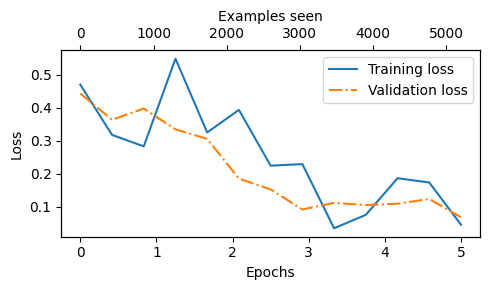

In [42]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

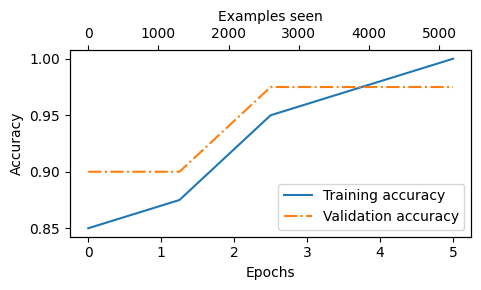

In [43]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [44]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.17%
Validation accuracy: 97.32%
Test accuracy: 96.67%


## 8 - 使用大模型作为垃圾邮件分类器

In [45]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]
    
    input_ids = input_ids[:min(max_length, supported_context_length)]
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)
    
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()
    
    return "spam" if predicted_label == 1 else "not spam"

In [46]:
# 测试

text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [47]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


### 模型保存与复用

In [48]:
# 保存模型
torch.save(model.state_dict(), "review_classifier.pth")

In [ ]:
# 加载模型
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)